In [12]:
from __future__ import unicode_literals

import sys
import os
from bs4 import BeautifulSoup
import urllib2
import cv2
from matplotlib import pyplot as plt
import matplotlib
import wikipedia

In [2]:
# from https://stackoverflow.com/questions/4460921/extract-the-first-paragraph-from-a-wikipedia-article-python
import re
import yaml
import urllib
import urllib2
import random

In [3]:
# set utf-8
stdi, stdo, stde = sys.stdin, sys.stdout, sys.stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde
sys.getdefaultencoding()

'utf-8'


In [14]:
# Set matplotlib font
matplotlib.rc('font', family='DejaVu Sans')


In [5]:
LANG = {
    'en': 'https://en.wikipedia.org',
    'zh': 'https://zh.wikipedia.org'
}

In [6]:
class WikipediaError(Exception):
    pass

In [7]:
class Wikipedia:
    url_article = 'http://%s.wikipedia.org/w/index.php?action=raw&title=%s'
    url_image = 'http://%s.wikipedia.org/w/index.php?title=Special:FilePath&file=%s'
    url_search = 'http://%s.wikipedia.org/w/api.php?action=query&list=search&srsearch=%s&sroffset=%d&srlimit=%d&format=yaml'
   
    def __init__(self, lang):
        self.lang = lang
   
    def __fetch(self, url):
        request = urllib2.Request(url)
        request.add_header('User-Agent', 'Mozilla/5.0')
       
        try:
            result = urllib2.urlopen(request)
        except urllib2.HTTPError, e:
            raise WikipediaError(e.code)
        except urllib2.URLError, e:
            raise WikipediaError(e.reason)
       
        return result
   
    def article(self, article):
        url = self.url_article % (self.lang, urllib.quote_plus(article))
        content = self.__fetch(url).read()
       
        if content.upper().startswith('#REDIRECT'):
            match = re.match('(?i)#REDIRECT \[\[([^\[\]]+)\]\]', content)
           
            if not match == None:
                return self.article(match.group(1))
           
            raise WikipediaError('Can\'t found redirect article.')
       
        return content
   
    def image(self, image, thumb=None):
        url = self.url_image % (self.lang, image)
        result = self.__fetch(url)
        content = result.read()
       
        if thumb:
            url = result.geturl() + '/' + thumb + 'px-' + image
            url = url.replace('/commons/', '/commons/thumb/')
            url = url.replace('/' + self.lang + '/', '/' + self.lang + '/thumb/')
           
            return self.__fetch(url).read()
       
        return content
   
    def search(self, query, page=1, limit=10):
        offset = (page - 1) * limit
        url = self.url_search % (self.lang, urllib.quote_plus(query), offset, limit)
        content = self.__fetch(url).read()
       
        parsed = yaml.load(content)
        search = parsed['query']['search']
       
        results = []
       
        if search:
            for article in search:
                title = article['title'].strip()
               
                snippet = article['snippet']
                snippet = re.sub(r'(?m)<.*?>', '', snippet)
                snippet = re.sub(r'\s+', ' ', snippet)
                snippet = snippet.replace(' . ', '. ')
                snippet = snippet.replace(' , ', ', ')
                snippet = snippet.strip()
               
                wordcount = article['wordcount']
               
                results.append({
                    'title' : title,
                    'snippet' : snippet,
                    'wordcount' : wordcount
                })
       
        # yaml.dump(results, default_style='', default_flow_style=False,
        #     allow_unicode=True)
        return results

In [8]:
def unwiki(wiki):
    """
   Remove wiki markup from the text.
   """
    wiki = re.sub(r'(?i)\{\{IPA(\-[^\|\{\}]+)*?\|([^\|\{\}]+)(\|[^\{\}]+)*?\}\}', lambda m: m.group(2), wiki)
    wiki = re.sub(r'(?i)\{\{Lang(\-[^\|\{\}]+)*?\|([^\|\{\}]+)(\|[^\{\}]+)*?\}\}', lambda m: m.group(2), wiki)
    wiki = re.sub(r'\{\{[^\{\}]+\}\}', '', wiki)
    wiki = re.sub(r'(?m)\{\{[^\{\}]+\}\}', '', wiki)
    wiki = re.sub(r'(?m)\{\|[^\{\}]*?\|\}', '', wiki)
    wiki = re.sub(r'(?i)\[\[Category:[^\[\]]*?\]\]', '', wiki)
    wiki = re.sub(r'(?i)\[\[Image:[^\[\]]*?\]\]', '', wiki)
    wiki = re.sub(r'(?i)\[\[File:[^\[\]]*?\]\]', '', wiki)
    wiki = re.sub(r'\[\[[^\[\]]*?\|([^\[\]]*?)\]\]', lambda m: m.group(1), wiki)
    wiki = re.sub(r'\[\[([^\[\]]+?)\]\]', lambda m: m.group(1), wiki)
    wiki = re.sub(r'\[\[([^\[\]]+?)\]\]', '', wiki)
    wiki = re.sub(r'(?i)File:[^\[\]]*?', '', wiki)
    wiki = re.sub(r'\[[^\[\]]*? ([^\[\]]*?)\]', lambda m: m.group(1), wiki)
    wiki = re.sub(r"''+", '', wiki)
    wiki = re.sub(r'(?m)^\*$', '', wiki)

    return wiki

def unhtml(html):
    """
   Remove HTML from the text.
   """
    html = re.sub(r'(?i)&nbsp;', ' ', html)
    html = re.sub(r'(?i)<br[ \\]*?>', '\n', html)
    html = re.sub(r'(?m)<!--.*?--\s*>', '', html)
    html = re.sub(r'(?i)<ref[^>]*>[^>]*<\/ ?ref>', '', html)
    html = re.sub(r'(?m)<.*?>', '', html)
    html = re.sub(r'(?i)&amp;', '&', html)

    return html

def punctuate(text):
    """
   Convert every text part into well-formed one-space
   separate paragraph.
   """
    text = re.sub(r'\r\n|\n|\r', '\n', text)
    text = re.sub(r'\n\n+', '\n\n', text)

    parts = text.split('\n\n')
    partsParsed = []

    for part in parts:
        part = part.strip()

        if len(part) == 0:
            continue

        partsParsed.append(part)

    return '\n\n'.join(partsParsed)


In [9]:
def article_urls_crawl(prefix, root_url, count):
    atc_list = set([])
    link_list = set([root_url])
    while True:
        url = link_list.pop()
        content = urllib.urlopen(url)
        print urllib.urlopen(url).headers.getheader('Content-Type')
        soup = BeautifulSoup(content, "html.parser")
        base=soup.find('div', id="bodyContent")

        for link in BeautifulSoup(str(base), "html.parser").findAll("a"):
            if 'href' in link.attrs:  # Make sure it is link
                if link['href'].startswith('/wiki/') and prefix + link['href'] != url:
                    link_list.add(prefix + link['href'])
                if ( 
                    link['href'].startswith('/wiki/') and  # Make sure it is a wiki page
                    len(link['href'].split('/')) == 3 and  # Make sure it is an article
                    len(link['href'].split(':')) == 1      # Make sure it is not category
                ):
#                     print(link['href'])
                    title = str(link['href'])
                    title = urllib.unquote(title).decode('utf8')
                    print title
                    atc_list.add(prefix + title)
                    if len(atc_list) == count:
                        print('fetched ' + str(count) + ' article urls from ' + prefix + '\n')
                        return atc_list

urls_by_lang = {}

for key in LANG:
    urls_by_lang[key] = article_urls_crawl(LANG[key], LANG[key], 50)

text/html; charset=UTF-8
/wiki/Wikipedia
/wiki/Free_content
/wiki/Encyclopedia
/wiki/English_language
/wiki/2017–18_Bergen_County_eruv_controversy
/wiki/Eruv
/wiki/Orthodox_Jews
/wiki/Shabbat
/wiki/Bergen_County,_New_Jersey
/wiki/Utility_pole
/wiki/Mahwah,_New_Jersey
/wiki/Upper_Saddle_River,_New_Jersey
/wiki/Montvale,_New_Jersey
/wiki/Rockland_County,_New_York
/wiki/Local_ordinance
/wiki/Anti-Semitism
/wiki/New_Jersey_Attorney_General
/wiki/2017–18_Bergen_County_eruv_controversy
/wiki/Suillus_spraguei
/wiki/Megalodon
/wiki/Interstate_80_in_Iowa
/wiki/Romanos_III_Argyros
/wiki/Zoë_Porphyrogenita
/wiki/Michael_IV_the_Paphlagonian
/wiki/Acrocnida_brachiata
/wiki/Echinocardium_cordatum
/wiki/Petra_Schmidt
/wiki/Rusalka_(opera)
/wiki/La_Gioconda_(opera)
/wiki/Musiktheater_im_Revier
/wiki/Gowanus_Canal
/wiki/Enterococcus
/wiki/Safavid_Georgia
/wiki/Georgians
/wiki/Persian_literature
/wiki/Religious_text
/wiki/2018_U.S._Figure_Skating_Championships
/wiki/Alysa_Liu
/wiki/2018_World_Junior_Fig

In [10]:
print urllib.unquote('%E8%8B%B1%E7%9A%87%E4%BD%90%E6%B2%BB%E4%BA%94%E4%B8%96%E5%AD%B8%E6%A0%A1').decode('utf8')
# print urls_by_lang

英皇佐治五世學校


/home/will/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


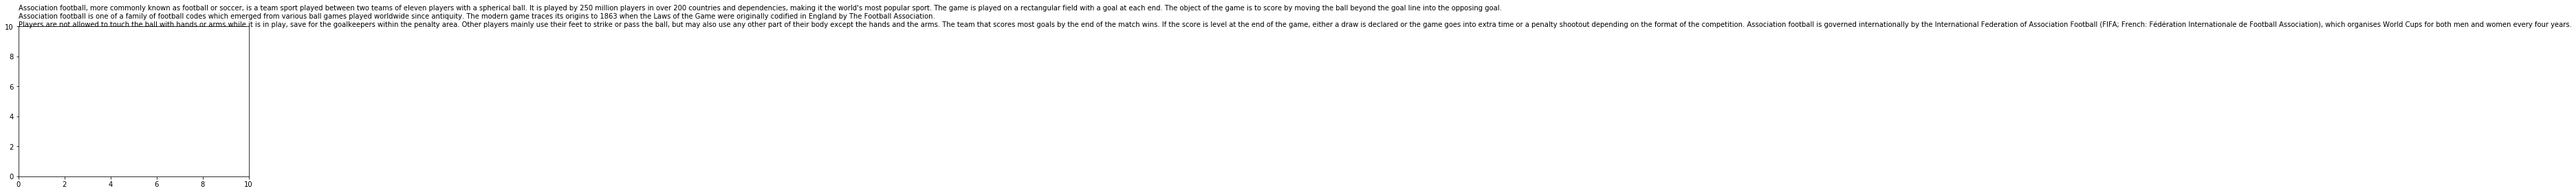

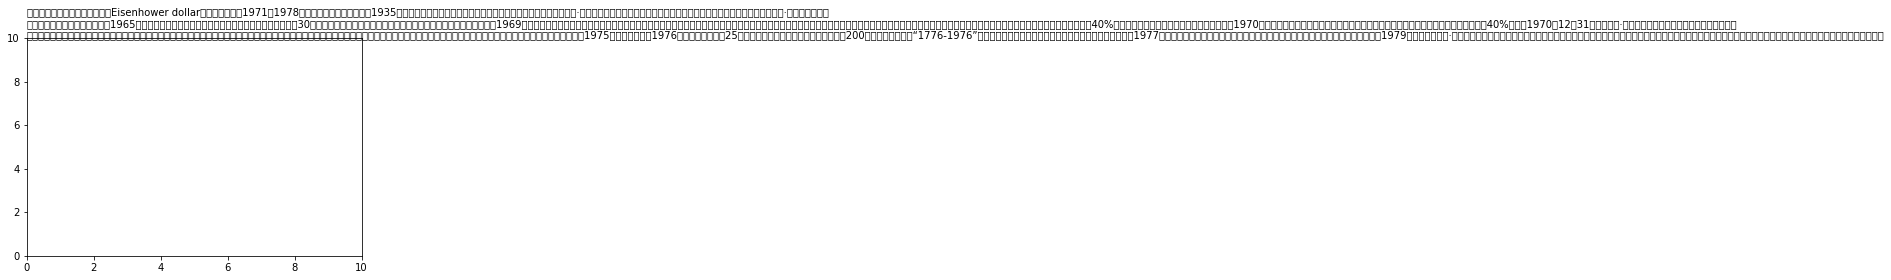

In [11]:
for key in LANG:
    wikipedia.set_lang(key)
    res = wikipedia.summary(random.choice(tuple(urls_by_lang[key])).split('/')[-1])
#     print res
    fig = plt.figure()
    plt.axis([0,10,0,10])
    plt.text(0, 10, res, ha='left', wrap=True)
    plt.show()